# Capture the Flag Miguel: Forecast de Nível do Rio Itajaí-Açu
O objetivo desse notebook é cobrir todas as etapas de desenvolvimento de um modelo de Machine Learning para previsão de nível do Rio Itajaí-Açu. Rio do Sul historicamente possui problemas de enchentes que afetam draticamente a cidade, impactando diretamente a vida da população. O modelo tentará prever o nível do rio, com uma certa precisão, baseado em dados históricos resgatados da API do [Open Meteo](https://open-meteo.com/) e também dos dados de nível do rio capturados pela [Defesa Civil de Rio do Sul](https://defesacivil.riodosul.sc.gov.br/).

Etapas:
- Coleta de dados via API e Webscraping ✅
- Análise Exploratória das Enchentes nos últimos 6 anos ⌛️
    - Relatório com indicadores, médias e gráficos sobre os acontencimentos de enchente
- Feature Engineering ⌛️
    - Criação de novas features
    - Inclusão de novas features (mais informações da API do Open Meteo)
- Treinamento do Modelo ⌛️
    - Comparação entre modelos (random forest vs xgboost vs outros)
    - Métricas de desempenho
    - Validação cruzada
    - Tuning de hiperparâmetros
    - Seleção da melhor target: water_level_next_1h, water_level_next_3h, water_level_next_6h e outros
- Avaliação de performance do melhor modelo ⌛️
- Deploy via API ⌛️
- Website contendo gráfico de nível com a previsão ⌛️
    - Vide exemplo: https://miro.medium.com/v2/resize:fit:1400/1*N3rDEJAvV_wolqXFl8HtEw.png

In [ ]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns

# add root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

In [3]:
from data.generate_data import generate

In [ ]:
## a

In [4]:
train_df = generate(
    start_date="2019-01-01",
    end_date="2024-12-31",
    type="train",
    save=False
)

2025-04-24 15:05:14.514 | INFO     | data.scraping:__init__:12 - WebScraper inicializado
2025-04-24 15:05:14.516 | INFO     | data.generate_data:__init__:31 - DataGenerator initialized with output directory: c:\Users\destr\OneDrive\Documentos\Enchentes\data\output
2025-04-24 15:05:14.517 | INFO     | data.generate_data:generate:170 - Generating train dataset from 2019-01-01 to 2024-12-31
2025-04-24 15:05:14.518 | INFO     | data.generate_data:_get_weather_data:44 - Fetching weather data from 2019-01-01 to 2024-12-31
2025-04-24 15:05:19.456 | INFO     | data.generate_data:_get_weather_data:48 - Weather data fetched successfully: (52608, 4) rows
2025-04-24 15:05:19.456 | INFO     | data.generate_data:_get_water_level_data:65 - Scraping water level data from 2019-01-01 to 2024-12-31
2025-04-24 15:05:19.456 | INFO     | data.scraping:parse_data:24 - Iniciando análise de dados de 2019-01-01 até 2024-12-31
2025-04-24 15:05:19.469 | INFO     | data.scraping:parse_data:30 - Serão processados 7

Processando intervalos:   0%|          | 0/731 [00:00<?, ?it/s]

2025-04-24 15:07:14.346 | WARNING  | data.scraping:parse_data:42 - Intervalo de datas vazio encontrado, pulando
2025-04-24 15:07:14.346 | INFO     | data.scraping:parse_data:68 - Análise de dados concluída com sucesso
2025-04-24 15:07:14.580 | INFO     | data.scraping:parse_data:80 - Formato final do DataFrame: (35747, 2)
2025-04-24 15:07:14.580 | INFO     | data.generate_data:_get_water_level_data:68 - Water level data scraped successfully: (35747, 2) rows
2025-04-24 15:07:14.603 | INFO     | data.generate_data:_merge_datasets:106 - Datasets merged successfully: (52608, 6) rows
2025-04-24 15:07:14.640 | INFO     | data.generate_data:_process_data:145 - Data processing completed: (52537, 17) rows


In [5]:
print(train_df)



                     time  temperature_2m  relative_humidity_2m  \
47    2019-01-02 23:00:00            25.6                    91   
48    2019-01-03 00:00:00            24.5                    96   
49    2019-01-03 01:00:00            24.3                    97   
50    2019-01-03 02:00:00            24.1                    98   
51    2019-01-03 03:00:00            24.0                    99   
...                   ...             ...                   ...   
52579 2024-12-30 19:00:00            21.6                    86   
52580 2024-12-30 20:00:00            21.2                    88   
52581 2024-12-30 21:00:00            20.7                    89   
52582 2024-12-30 22:00:00            21.0                    88   
52583 2024-12-30 23:00:00            20.6                    89   

       apparent_temperature  rain  water_level  hour  day_of_week  month  \
47                     30.6   0.0         1.08    23            2      1   
48                     29.8   0.0         1

In [69]:
# Calcular média do nível do rio por mês
year_df = train_df[train_df['time'].dt.year == 2023]
year_df['mes'] = year_df['time'].dt.month
media_ano = year_df.groupby('mes')['water_level'].mean().reset_index()
media_ano


C:\Users\destr\AppData\Local\Temp\ipykernel_12080\351556252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['mes'] = year_df['time'].dt.month


,mes,water_level
0,1,2.986082
1,2,2.884427
2,3,2.742628
3,4,2.531639
4,5,1.676277
5,6,2.199139
6,7,3.233266
7,8,2.232722
8,9,2.924354
9,10,7.342103


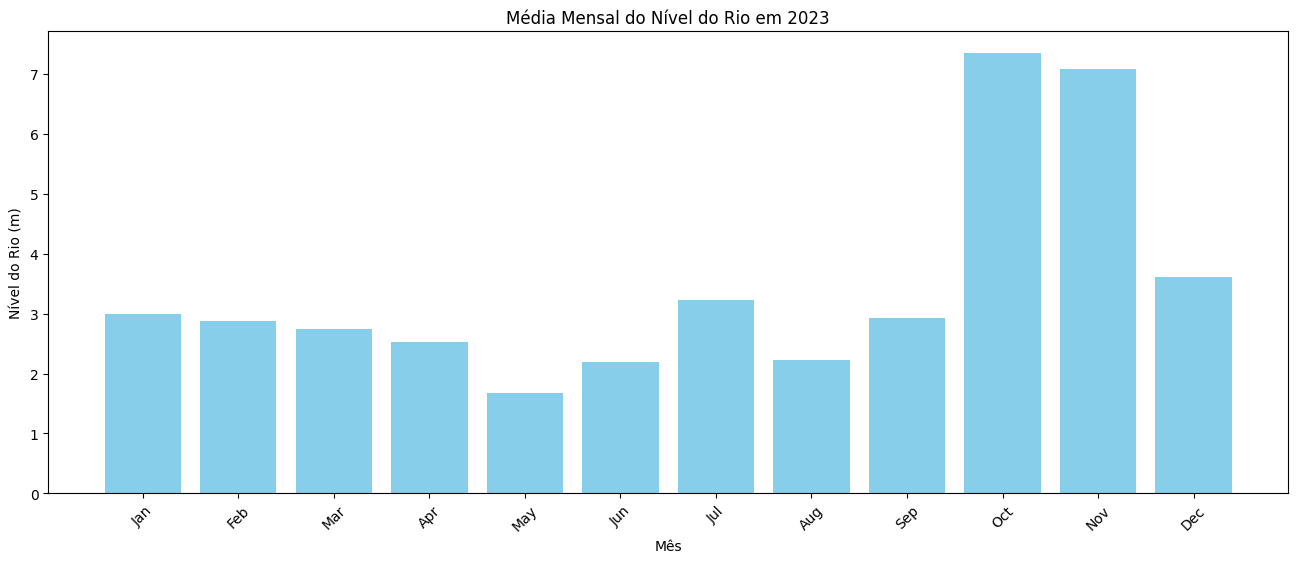

In [70]:
plt.bar(media_ano['mes'], media_ano['water_level'], color='skyblue')
plt.xlabel('Mês')
plt.ylabel('Nível do Rio (m)')
plt.title('Média Mensal do Nível do Rio em 2023')
plt.xticks(rotation=45)
plt.xticks(media_ano['mes'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.gcf().set_size_inches(16, 6)
plt.show()

In [80]:
month_df = train_df[train_df['time'].dt.year == 2023]
month_df['mes'] = month_df['time'].dt.month
month_df = month_df.loc[month_df['mes'] == 10]
month_df['dia'] = month_df['time'].dt.day
day_df = month_df.groupby('dia')['water_level'].mean().reset_index()
#mean_month = month_df.groupby('mes')['water_level'].mean().reset_index()
day_df

C:\Users\destr\AppData\Local\Temp\ipykernel_12080\1415852259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df['mes'] = month_df['time'].dt.month


,dia,water_level
0,1,4.055833
1,2,4.231250
2,3,3.728333
3,4,5.586667
4,5,7.849167
5,6,6.996250
6,7,7.842083
7,8,9.907292
8,9,10.775000
9,10,10.532917


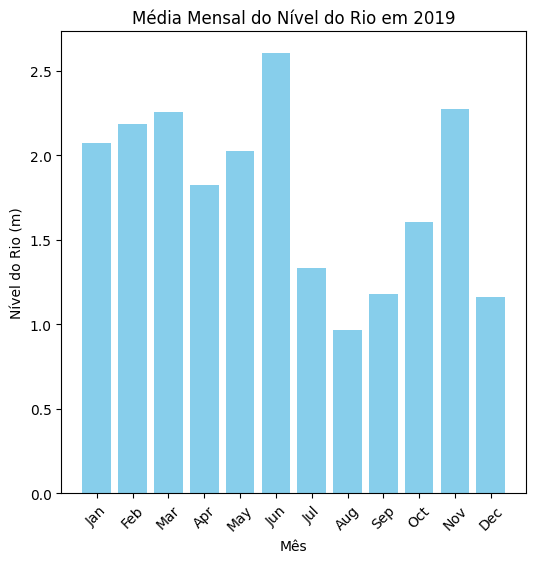

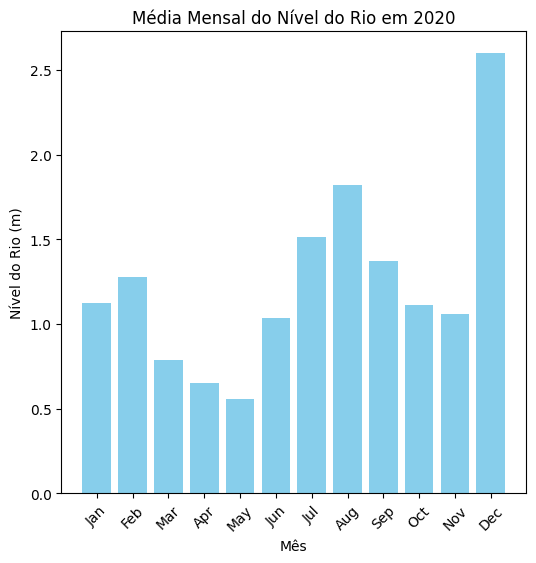

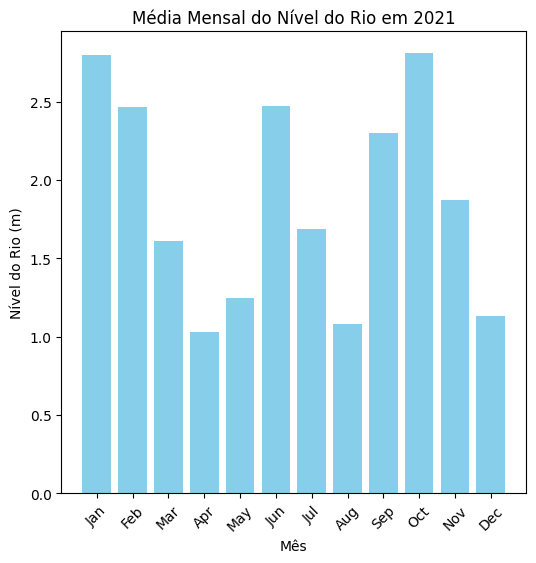

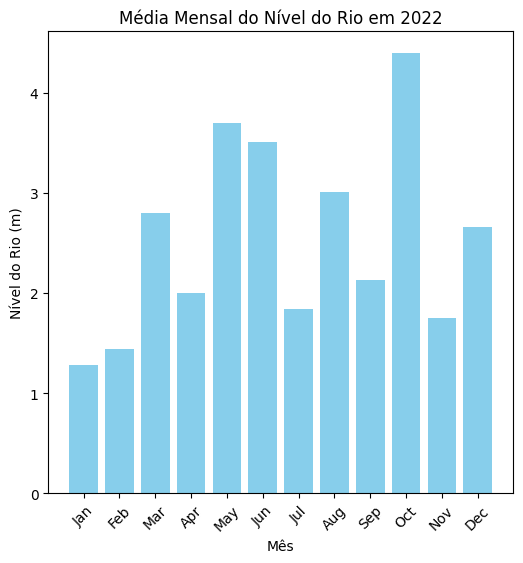

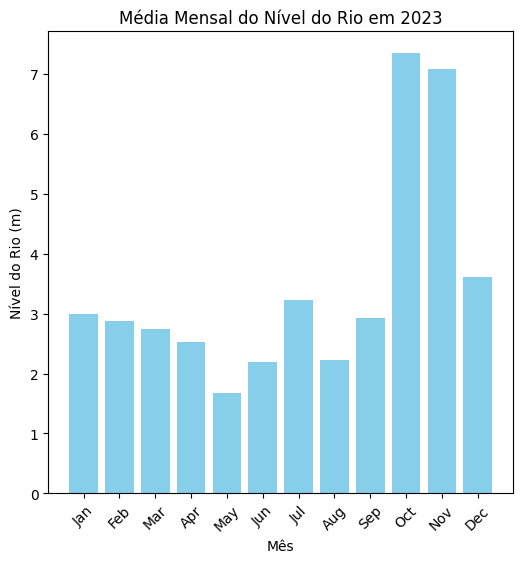

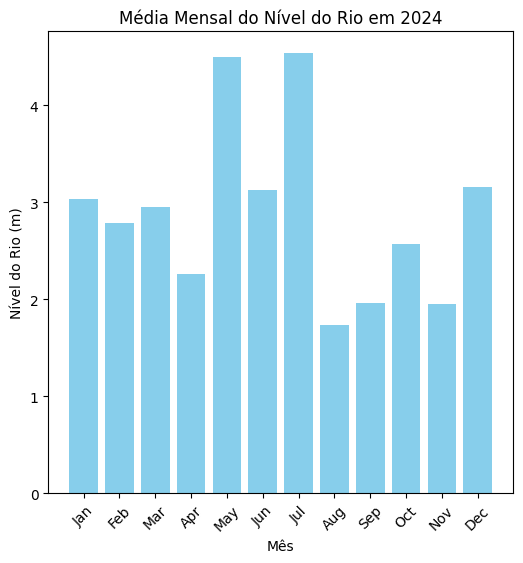

In [103]:
def month_set(ano):
    year_df = train_df[train_df['time'].dt.year == ano].copy()
    year_df['mes'] = year_df['time'].dt.month
    media_ano = year_df.groupby('mes')['water_level'].mean().reset_index()
    return media_ano

def plot_month(ano, media_ano):
    plt.bar(media_ano['mes'], media_ano['water_level'], color='skyblue')
    plt.xlabel('Mês')
    plt.ylabel('Nível do Rio (m)')
    plt.title(f'Média Mensal do Nível do Rio em {ano}')
    plt.xticks(media_ano['mes'], 
               ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(6, 6)
    plt.show()

def loop_func(ano_inicial):
    if ano_inicial == 2019:
        while ano_inicial <= 2024:
            media = month_set(ano_inicial)
            plot_month(ano_inicial, media)
            ano_inicial += 1
    else:
        print("Erro: ano inicial deve ser 2019")
loop_func(2019)

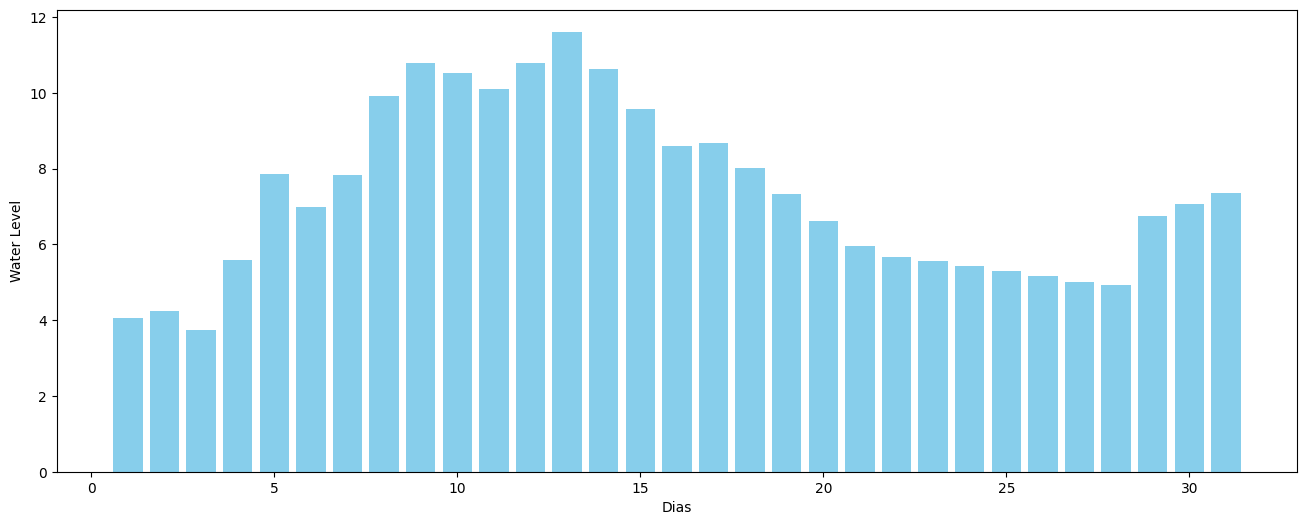

In [74]:
plt.bar(day_df['dia'], day_df['water_level'], color='skyblue')
plt.ylabel('Water Level')
plt.xlabel('Dias')
plt.gcf().set_size_inches(16, 6)
plt.show()

In [104]:
month_df.loc[month_df['time'].isin(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05'])]
#month_df.loc[month_df['time'].isin(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29'])]

C:\Users\destr\AppData\Local\Temp\ipykernel_12080\2645077238.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  month_df.loc[month_df['time'].isin(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05'])]


,time,temperature_2m,relative_humidity_2m,apparent_temperature,rain,water_level,hour,day_of_week,month,rain_24h,temperature_24h_avg,humidity_24h_avg,water_level_next_1h,water_level_next_3h,water_level_next_6h,water_level_next_12h,water_level_next_24h,mes,dia
41616,2023-10-01,18.0,100,19.8,0.4,3.98,0,6,10,15.7,18.966667,90.083333,4.00,4.040000,4.050000,3.98,4.26,10,1
41640,2023-10-02,16.1,85,15.6,0.0,4.26,0,0,10,0.4,19.679167,83.000000,4.26,4.254545,4.246364,4.23,4.20,10,2
41664,2023-10-03,14.2,75,13.1,0.0,4.20,0,1,10,0.0,17.337500,80.041667,4.19,4.150000,4.070000,3.77,2.95,10,3
41688,2023-10-04,17.1,89,18.3,0.0,2.95,0,2,10,0.0,18.304167,74.958333,2.91,2.830000,3.030000,6.10,8.29,10,4
41712,2023-10-05,17.2,100,19.0,0.0,8.29,0,3,10,38.8,17.579167,96.708333,8.29,8.206364,8.080909,7.83,7.37,10,5


## Correlação ##

In [112]:
features = month_df.loc[:, ['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
features_df = pd.DataFrame(data=features)
features_df.corr()

,temperature_2m,relative_humidity_2m,apparent_temperature,rain,rain_24h,temperature_24h_avg,humidity_24h_avg,water_level_next_3h
temperature_2m,1.000000,-0.549074,0.970498,0.002943,0.069616,0.583212,-0.032232,-0.232308
relative_humidity_2m,-0.549074,1.000000,-0.380238,0.312863,0.364605,0.016891,0.459531,0.151534
apparent_temperature,0.970498,-0.380238,1.000000,0.077595,0.184961,0.645059,0.080669,-0.221597
rain,0.002943,0.312863,0.077595,1.000000,0.382955,0.074035,0.278176,0.052077
rain_24h,0.069616,0.364605,0.184961,0.382955,1.000000,0.079959,0.757017,0.243957
temperature_24h_avg,0.583212,0.016891,0.645059,0.074035,0.079959,1.000000,-0.052457,-0.314356
humidity_24h_avg,-0.032232,0.459531,0.080669,0.278176,0.757017,-0.052457,1.000000,0.374287
water_level_next_3h,-0.232308,0.151534,-0.221597,0.052077,0.243957,-0.314356,0.374287,1.000000


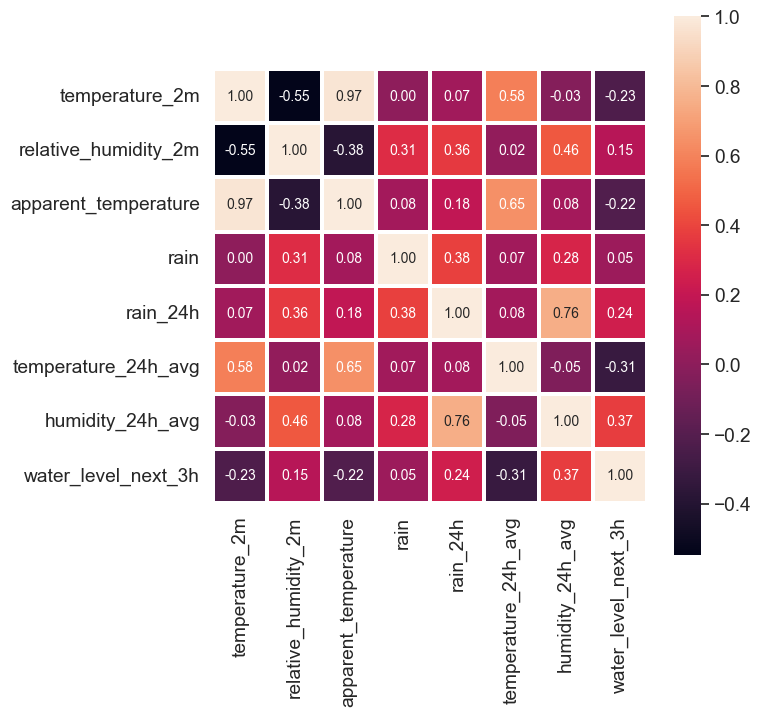

In [115]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(features_df.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=features_df.columns , xticklabels=features_df.columns
            )
plt.show()

*apperent_temperature (excluído) -> Correlação de 0.97 com temperature_2m

## Modelos básicos de regressão do Scikit-learn e comparação de resultados ##

**Serão testados os seguintes modelos:**

LinearRegression

Ridge

Lasso

Elastic Net

Stochastic Gradient Descent

DecisionTreeRegressor

RandomForestRegressor

SVR

GXBoost

In [ ]:
#from sklearn.model_selection import GridSearchCV
#score_calc = 'neg_mean_squared_error'

LinearRegression

In [146]:
from sklearn.linear_model import LinearRegression
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mliearn = LinearRegression()
mliearn.fit(X_train, y_train)
y_pred = mliearn.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 6.900812250924143e-29
R² (coeficiente de determinação): 1.0


Rigde

In [147]:
from sklearn.linear_model import Ridge
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mridge = Ridge(alpha=1.0)
mridge.fit(X_train, y_train)
y_pred = mridge.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 7.225452730213182e-07
R² (coeficiente de determinação): 0.9999998692396789


Lasso

In [148]:
from sklearn.linear_model import Lasso
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlasso = Lasso(alpha=0.1)
mlasso.fit(X_train, y_train)
y_pred = mlasso.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.002118881535031146
R² (coeficiente de determinação): 0.999616542187187


Elastic net

In [149]:
from sklearn.linear_model import ElasticNet
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
modelo_elastic.fit(X_train, y_train)
y_pred = modelo_elastic.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.0020831178811408437
R² (coeficiente de determinação): 0.9996230144001315


Stochastic Gradient Descent


In [150]:
from sklearn.linear_model import SGDRegressor
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_sgd = SGDRegressor(
penalty='l2',        # 'l2' = Ridge, 'l1' = Lasso, 'elasticnet' = ambos
alpha=0.001,         # força da regularização
max_iter=1000,       # número máximo de iterações
tol=1e-3,            # tolerância pro critério de parada
random_state=42
)
modelo_sgd.fit(X_train, y_train)
y_pred = modelo_sgd.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 1.1846114796237054e+26
R² (coeficiente de determinação): -2.1438127592302378e+25


DecisionTreeRegressor


In [151]:
from sklearn.tree import DecisionTreeRegressor
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_arvore = DecisionTreeRegressor(random_state=42, max_depth=5)
modelo_arvore.fit(X_train, y_train)
y_pred = modelo_arvore.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.007172226283222515
R² (coeficiente de determinação): 0.9987020292743624


RandomForestRegressor

In [152]:
from sklearn.ensemble import RandomForestRegressor
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_floresta = RandomForestRegressor(random_state=42, n_estimators=100)
modelo_floresta.fit(X_train, y_train)
y_pred = modelo_floresta.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.00043700133548728066
R² (coeficiente de determinação): 0.9999209150801818


SVR

In [153]:
from sklearn.svm import SVR
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_svr = SVR(kernel='rbf')
modelo_svr.fit(X_train, y_train)
y_pred = modelo_svr.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 2.9994393123399923
R² (coeficiente de determinação): 0.45718605813495705


XGBOOST

In [ ]:
import xgboost as xgb
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_3h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror')
modelo_xgb.fit(X_train, y_train)
y_pred = modelo_xgb.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.0011706479495527408
R² (coeficiente de determinação): 0.9997881457292972


### Resultado: O Linear Regressor obteve o melhor resultado de previsão ###